In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [29]:

# Load data
df2 = pd.read_excel('Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')
df = df2.copy()



# Define Traverse assignment function (same as before)
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    if gns.startswith("S1"):
        return "Traverse 1*" if gns in ["S1m", "S1i"] else "Traverse 1"
    elif gns.startswith("S2"):
        return "Traverse 2"
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:
            return "Traverse 3*"
        return "Traverse 3"
    elif gns.startswith("S4"):
        return "Traverse 5*" if gns in ["S4m", "S4l"] else "Traverse 5"
    return None




df["Traverse"] = df["GNS"].apply(assign_traverse)
df = df[df["Traverse"] == "Traverse 3"]


In [30]:



# Convert Li concentrations to millimolar
df['Li_mM'] = df['Li_ppm'] / 6.94

# Convert Li concentrations to nanomolar
df['Li_nM'] = df['Li_ppm'] * 1000000 / 6.94

# Convert Li concentrations to mol/m^3 (from nM)
df['Li_mol_m3'] = df['Li_nM'] * 1e-6  # Convert nM to mol/m^3

####################

# Let's try to model the Si concentration

df['Si_mM'] = df['Si_ppm'] / 28.0855

# convert Si to mol/m^3

df['Si_mol_m3'] = df['Si_mM'] * 1e-3




In [31]:
variable = 'Si_mol_m3'

min_variable = df[variable].min()
max_variable = df[variable].max()


df["z'"] = (df[variable] - min_variable) / (max_variable - min_variable)



# Reaction rate constant k (log10 form) and unit conversion
log_k = -11.2  # Example log10 k value
k = np.exp(log_k)  # Convert to mol/m^2/s
A_s = 1  # Assume unit specific surface area for simplicity



In [32]:


# Function to calculate N_D
def calculate_ND(phi, t, C0, k, A_s):
    """
    Calculate the Damköhler number N_D.
    phi: porosity
    t: time (h/w, in seconds)
    C0: initial concentration (in mol/m^3)
    k: reaction rate constant (in mol/m^2/s)
    A_s: specific surface area (in m^2/m^3)
    """
    return t * k * A_s / (phi * C0)



def EE(z, N_D, f, C0):
    """
    Explicit Euler method to solve for C' as a function of z'.
    
    Parameters:
        z: array of nondimensional distances (z')
        N_D: Damköhler number
        f: reaction fraction
        C0: initial concentration (C' at z'=0)
    
    Returns:
        C: array of concentrations at each z'
    """
    dz = z[1] - z[0]  # Step size in nondimensional distance
    C = np.zeros_like(z)  # Initialize concentration array
    C[0] = C0  # Set initial concentration
    
    for i in range(1, len(z)):
        # Update concentration using Explicit Euler formula
        C[i] = C[i-1] + dz * N_D * (1 - f)
    
    return C




In [39]:

# Objective function for optimization
def objective(params):
    phi, t, f = params  # Unpack porosity, time, and reaction fraction
    z = np.linspace(0, 1, 100)  # Nondimensional grid
    C0 = df[variable].min()  # Initial concentration in mol/m^3
    N_D = calculate_ND(phi, t, C0, k, A_s)  # Calculate N_D (diffusion number)
    C_model = EE(z, N_D, f, C0)  # Compute the model concentration
    C_model_interp = np.interp(df["z'"], z, C_model)  # Interpolate to match data
    # Return the sum of squared errors
    return np.sum((C_model_interp - df[variable])**2)


In [40]:

initial_phi = 0.3  # Initial guess for porosity
initial_t = 25 * 365 * 24 * 3600  # Initial guess for time (h/w)
initial_f = 0.5  # Initial guess for reaction fraction

initial_guess = [initial_phi, initial_t, initial_f]

# Bounds for the parameters: (phi, t, f)
bounds = [(0.01, 0.1),  # Porosity range
          (86400, 3153600000),  # Time range of one day to 100 years
          (0.0, 1.0)]   # Fraction of reaction range


# Perform optimization
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
phi_opt, t_opt, f_opt = result.x
print(f"Optimized porosity (phi): {phi_opt}")

t_opt_years = t_opt / (365 * 24 * 3600)

print(f"Optimized time (t/years): {t_opt_years}")


print(f"Optimized fraction of reaction (f): {f_opt}")



z = np.linspace(0, 1, 100)
C0 = df[variable].min()
N_D = calculate_ND(phi_opt, t_opt, C0, k, A_s)
C_model_opt = EE(z, N_D, f_opt, C0)

print(C_model_opt)

# Interpolate for plotting
C_model_interp = np.interp(df["z'"], z, C_model_opt)



#range of C_model_interp
C_model_interp_min = C_model_interp.min()
C_model_interp_max = C_model_interp.max()




Optimized porosity (phi): 0.1
Optimized time (t/years): 24.954715816765166
Optimized fraction of reaction (f): 1.0
[0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117 0.00010117
 0.00010117 0.

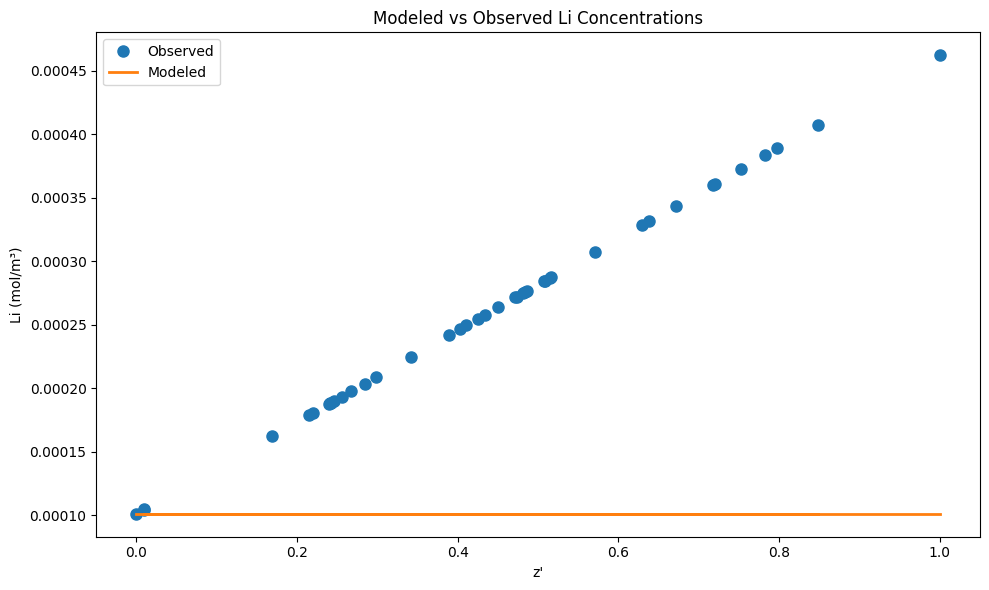

In [35]:

# Plot observed vs modeled
plt.figure(figsize=(10, 6))
plt.plot(df["z'"], df[variable], 'o', label='Observed', markersize=8)
plt.plot(df["z'"], C_model_interp, '-', label='Modeled', linewidth=2)
plt.xlabel("z'")
plt.ylabel("Li (mol/m³)")
plt.title("Modeled vs Observed Li Concentrations")
plt.legend()
plt.tight_layout()
plt.show()